# Démonstration de la recherche des lemmes dans les réponses

Illustration de l'analyse Boolénne du grand débat national par le traitement de la question 33 du domaine Démocratie et Citoyenneté:

### "Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?"

## Importation des librairies 

In [1]:
# coding: utf-8
import gensim
import smart_open
import numpy as np
import string

### Télécharger le fichier des réponses à la question  
rep_demo33 (sous la forme raw, par exemple: wget https://raw.githubusercontent.com/weisbuch/Grand-debat/master/rep_demo33)

## Préfiltrage du fichier des réponses
  On définit la fonction read_corpus qui lit chaque réponse (donc ligne par ligne) en isolant les mots, et supprime la ponctuation, change les majuscules en minuscules etc. puis on l'applique au fichier des réponses.
  On obtient ainsi l'ensemble des réponses filtrées rep_fil.

In [2]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="utf-8") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

rep_fil = list(read_corpus('rep_demo33', tokens_only=True))
print(len(rep_fil))

72839


### Testons les réponses filtrées en fonction de leur numéro
en changeant éventuellemment les numéros des réponses à lire.

In [3]:
rep_fil[22:24]

[['éducation'],
 ['que',
  'chaque',
  'citoyen',
  'percevant',
  'des',
  'aides',
  'de',
  'état',
  'puisse',
  'durant',
  'cette',
  'période',
  'participer',
  'aux',
  'travaux',
  'de',
  'sa',
  'commune']]

### On établit ici la liste des lemmes à tester à partir de la lecture d'une centaine de réponses.  
liste_lemme est une liste de listes. Attention à la syntaxe!

In [4]:
liste_lemme=[]
lla=liste_lemme.append
lla(['service','engagement','écoute']) 
lla(['référendum','RIC','vote','votes']) 
lla(['instruction','éducation','éducations','civique','économie','contribution','association','peuple','citoyen']) 

# L'analyse démarre ici.
 On code en décimal la présence (par le bit 1) ou l'absence (par le bit 0) de mots ou leurs équivalents (lemmes) dans une réponse. Le bit de gauche (MSB) code la présence du premier lemme, celui du milieu celle second et le troisième (LSB) celle du troisième lemme.
 
| code binaire | 000 | 001 | 010 | 011 | 100 | 101 | 110 | 111 |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----| 
| code décimal |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  | 
Le code décimal est utilisé comme indice j du vecteur count qui enregistre le nombre des réponses en fonction des lemmes présents. 
 

In [6]:
c=[]
for i in range(3):
    c.append(0)
z=0 #z est la représentation décimale
count=np.zeros(50,'int32')
for i in range(len(rep_fil)):
#for i in range(20)lla(['service','engagement','écoute'])
    z=0
    mul=1
    k=-1
    for lem in liste_lemme:
        mul*=2
        k+=1
        for mot in lem:
            if mot in rep_fil[i]:
                z+=mul
                c[k]+=1
                break  
    zz=z//2
    count[zz]+=1
# la boucle de comptage finit ici

ccompte=0  # les réponses contenant au moins un lemme
print("non reconnus ", end =" ")
liste=[]  
labels=[]  # le premier mot du lemme servant de caractéristique
for i in range(3):
    labels.append(liste_lemme[i][0])
for j in range(8):    
    ccompte+=count[j+1] # total des réponses captatrices
    liste.append(count[j+1])
#    print(j-1,count[j-1],'\n')
    if j%2==1:
        print(liste_lemme[0][0],end =" ")
    if j&2 > 0:
        print(liste_lemme[1][0],end =" ")
    if j&4 > 0:
        print(liste_lemme[2][0],end =" ")
#    if j&8:
#        print(liste_lemme[3][0],end =" ")
    print(count[j],'\n')
print ('réponses reconnues',ccompte)
for i in range(3):
    print(liste_lemme[i][0],c[i],end =" ")
print(" ")  
for i in range(3):
    print(liste_lemme[i][0],"{0:.1f}".format(100*c[i]/ccompte),'%',end =" ")
    
    

non reconnus  41374 

service 7354 

référendum 3690 

service référendum 246 

instruction 9409 

service instruction 9768 

référendum instruction 578 

service référendum instruction 420 

réponses reconnues 31465
service 17788 référendum 4934 instruction 20175  
service 56.5 % référendum 15.7 % instruction 64.1 % 

# Tracé du diagramme de Venn
Le diagramme de Venn est la représentation graphique de ces résultats.
La surface de chaque portion de cercle est proportionnelle au nombre de
réponses  mentionnant les lemmes. Les trois cercles complets de couleur brique,
verte et bleue  correspondent respectivement aux lemmes service, référendum et instruction.
Les intersections aux couleurs composites correspondent aux réponses mixtes mentionnant deux ou trois lemmes. Les chiffres sont les nombres de réponses
correspondantes.

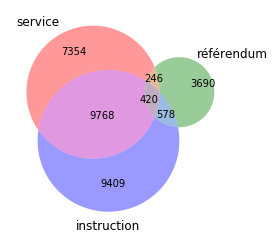

In [7]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
# Make the diagram
venn3(subsets =liste,set_labels=labels)
#plt.savefig('figure-demo27-sans.pdf')
plt.show()